# Importing Libraries and Loading Dataset

In [1]:
import numpy as np
import pandas as pd
from datasets import load_dataset
import torch
from datasets import Dataset, DatasetDict
import matplotlib.pyplot as plt
from transformers import pipeline
from sklearn.model_selection import train_test_split
import os

# Importing Samsum Dataset from Kaggle

In [2]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


In [3]:
# !pip install py7zr

In [4]:
# pip install --upgrade datasets


In [5]:
# import shutil
# import os

# # Specify the path to the cache directory (replace with your actual path)
# cache_dir = "file:///home/skaranam/.cache/huggingface/datasets/samsum/samsum/0.0.0/f1d7c6b7353e6de335d444e424dc002ef70d1277109031327bc9cc6af5d3d46e"

# # Delete the cached dataset folder
# shutil.rmtree(cache_dir, ignore_errors=True)


# Loading and Exploring the Dataset

In [6]:
dataset_samsum = load_dataset("samsum")

In [7]:
dataset_samsum

DatasetDict({
    train: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 14732
    })
    test: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 819
    })
    validation: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 818
    })
})

In [8]:
dataset_samsum["train"][0:5]

{'id': ['13818513', '13728867', '13681000', '13730747', '13728094'],
 'dialogue': ["Amanda: I baked  cookies. Do you want some?\r\nJerry: Sure!\r\nAmanda: I'll bring you tomorrow :-)",
  'Olivia: Who are you voting for in this election? \r\nOliver: Liberals as always.\r\nOlivia: Me too!!\r\nOliver: Great',
  "Tim: Hi, what's up?\r\nKim: Bad mood tbh, I was going to do lots of stuff but ended up procrastinating\r\nTim: What did you plan on doing?\r\nKim: Oh you know, uni stuff and unfucking my room\r\nKim: Maybe tomorrow I'll move my ass and do everything\r\nKim: We were going to defrost a fridge so instead of shopping I'll eat some defrosted veggies\r\nTim: For doing stuff I recommend Pomodoro technique where u use breaks for doing chores\r\nTim: It really helps\r\nKim: thanks, maybe I'll do that\r\nTim: I also like using post-its in kaban style",
  "Edward: Rachel, I think I'm in ove with Bella..\r\nrachel: Dont say anything else..\r\nEdward: What do you mean??\r\nrachel: Open your fu

# Splitting the Data and Displaying Sample Dialogues

In [9]:
split_lengths = [len(dataset_samsum[split]) for split in dataset_samsum]

In [10]:
split_lengths

[14732, 819, 818]

In [11]:
print(f"Split lengths: {split_lengths}")
print(f"Features: {dataset_samsum['train'].column_names}")
print("\nDialogue:")
print(dataset_samsum["test"][0]["dialogue"])
print("\nSummary:")
print(dataset_samsum["test"][0]["summary"])

Split lengths: [14732, 819, 818]
Features: ['id', 'dialogue', 'summary']

Dialogue:
Hannah: Hey, do you have Betty's number?
Amanda: Lemme check
Hannah: <file_gif>
Amanda: Sorry, can't find it.
Amanda: Ask Larry
Amanda: He called her last time we were at the park together
Hannah: I don't know him well
Hannah: <file_gif>
Amanda: Don't be shy, he's very nice
Hannah: If you say so..
Hannah: I'd rather you texted him
Amanda: Just text him 🙂
Hannah: Urgh.. Alright
Hannah: Bye
Amanda: Bye bye

Summary:
Hannah needs Betty's number but Amanda doesn't have it. She needs to contact Larry.


In [12]:
# !pip install sentencepiece
# !pip install protobuf==3.20

In [13]:
# !pip install accelerate>=0.20.1


In [14]:
# pip install --upgrade transformers


## Applying pegasus directly on our dataset
#### We generate the output without finetuning

In [15]:
pipe = pipeline("summarization", model="google/pegasus-cnn_dailymail")

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-cnn_dailymail and are newly initialized: ['model.encoder.embed_positions.weight', 'model.decoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:
pipe_out = pipe(dataset_samsum["test"][0]["dialogue"])
print("Summary:")
print(pipe_out[0]["summary_text"].replace(" .<n>", ".\n"))

Your max_length is set to 128, but your input_length is only 122. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=61)


Summary:
Amanda: Ask Larry Amanda: He called her last time we were at the park together.
Hannah: I'd rather you texted him.
Amanda: Just text him .


## We can see that the summarization is not accurate and doesnot look like a summary

In [17]:
device = "cuda" if torch.cuda.is_available() else "cpu"
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

model_ckpt = "google/pegasus-cnn_dailymail"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = AutoModelForSeq2SeqLM.from_pretrained(model_ckpt).to(device)
d_len = [len(tokenizer.encode(s)) for s in dataset_samsum["train"]["dialogue"]]
s_len = [len(tokenizer.encode(s)) for s in dataset_samsum["train"]["summary"]]

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-cnn_dailymail and are newly initialized: ['model.encoder.embed_positions.weight', 'model.decoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Token indices sequence length is longer than the specified maximum sequence length for this model (1044 > 1024). Running this sequence through the model will result in indexing errors


## Plotting Distribution of Dialogue Token Length and Summary Token Length

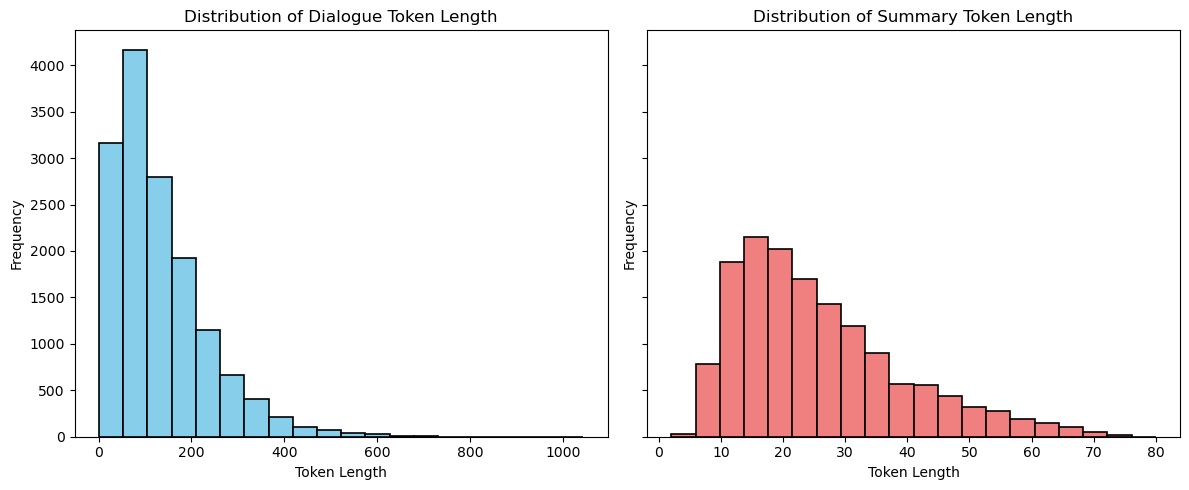

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

axes[0].hist(d_len, bins=20, color='skyblue', edgecolor='black', linewidth=1.2)
axes[0].set_title("Distribution of Dialogue Token Length")
axes[0].set_xlabel("Token Length")
axes[0].set_ylabel("Frequency")

axes[1].hist(s_len, bins=20, color='lightcoral', edgecolor='black', linewidth=1.2)
axes[1].set_title("Distribution of Summary Token Length")
axes[1].set_xlabel("Token Length")
axes[1].set_ylabel("Frequency")

plt.tight_layout()
plt.show()


In [19]:
tokenizer.as_target_tokenizer()

In [20]:
def convert_examples_to_features(example_batch):
    # Encode dialogue text
    input_encodings = tokenizer(
        example_batch["dialogue"],
        max_length=1024,
        truncation=True,
        padding="max_length",  # Add padding to make the input sequences equal length
    )

    # Encode summary text separately using target tokenizer
    with tokenizer.as_target_tokenizer():
        target_encodings = tokenizer(
            example_batch["summary"],
            max_length=128,
            truncation=True,
            padding="max_length",  # Add padding to make the target sequences equal length
        )

    # Return the formatted input for the model
    return {
        "input_ids": input_encodings["input_ids"], 
        "attention_mask": input_encodings["attention_mask"],  
        "labels": target_encodings["input_ids"]
    }


In [21]:
dataset_samsum_pt = dataset_samsum.map(convert_examples_to_features, batched=True)

Map:   0%|          | 0/818 [00:00<?, ? examples/s]

/home/skaranam/.local/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:3856: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


In [22]:
columns = ["input_ids", "labels", "attention_mask"]
dataset_samsum_pt.set_format(type="torch", columns=columns)

In [23]:
from transformers import DataCollatorForSeq2Seq

seq2seq_data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

In [24]:
# !pip install transformers>=4.0.0
# !pip install accelerate>=0.20.1


# Finetuning Pegasus Model

In [25]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments( output_dir="pegasus-finetune",
                                 num_train_epochs=1,
                                 warmup_steps=500,
                                 per_device_train_batch_size=1,
                                 per_gpu_eval_batch_size=1,
                                 weight_decay=0.01,
                                 logging_steps=10, 
                                 push_to_hub=True,
                                 evaluation_strategy='steps', 
                                 eval_steps=500,
                                 save_steps=1e6,
                                 gradient_accumulation_steps=16,
                                 report_to="none") #wandb disabled

In [26]:
from huggingface_hub import notebook_login

notebook_login()

In [29]:
trainer = Trainer(
    model=model,
    args=training_args,
    tokenizer=tokenizer,
    data_collator=seq2seq_data_collator,
    train_dataset=dataset_samsum_pt["train"],
    eval_dataset=dataset_samsum_pt["validation"]
)



Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


In [31]:
trainer.train()

Step,Training Loss,Validation Loss


TrainOutput(global_step=230, training_loss=9.344054512355639, metrics={'train_runtime': 3445.4671, 'train_samples_per_second': 4.276, 'train_steps_per_second': 0.067, 'total_flos': 4.271784189965107e+16, 'train_loss': 9.344054512355639, 'epoch': 1.0})

In [32]:
trainer.push_to_hub("Training complete.")

Using deprecated `--per_gpu_eval_batch_size` argument which will be removed in a future version. Using `--per_device_eval_batch_size` is preferred.
Using deprecated `--per_gpu_eval_batch_size` argument which will be removed in a future version. Using `--per_device_eval_batch_size` is preferred.


training_args.bin:   0%|          | 0.00/4.54k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.28G [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

'https://huggingface.co/srisyamsaran/pegasus-finetune/tree/main/'

In [33]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

model_ckpt = "srisyamsaran/pegasus-finetune"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = AutoModelForSeq2SeqLM.from_pretrained(model_ckpt).to(device)

model.safetensors:   0%|          | 0.00/2.28G [00:00<?, ?B/s]

In [34]:
#!pip install rouge_score

# Evaluate Summaries using ROUGE Metric

In [35]:
from datasets import load_metric
from tqdm import tqdm

rouge_metric = load_metric("rouge")
rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]

/scratch/local/ipykernel_3270/257967448.py:4: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  rouge_metric = load_metric("rouge")


In [36]:
def chunks(list_of_elements, batch_size):
    """Yield successive batch-sized chunks from list_of_elements.""" 
    for i in range(0, len(list_of_elements), batch_size):
        yield list_of_elements[i : i + batch_size]

In [37]:
def evaluate_summaries_pegasus(dataset, metric, model, tokenizer, batch_size=8, device=device,
                                   column_text="article",
                                   column_summary="highlights"):
    
    article_batches = list(chunks(dataset[column_text], batch_size))
    target_batches = list(chunks(dataset[column_summary], batch_size)) 
        
    for article_batch, target_batch in tqdm(zip(article_batches, target_batches), total=len(article_batches)):
            inputs = tokenizer(article_batch, max_length=1024,  truncation=True,
                            padding="max_length", return_tensors="pt")
            print(type(article_batch))
            summaries = model.generate(input_ids=inputs["input_ids"].to(device),
                             attention_mask=inputs["attention_mask"].to(device),
                             length_penalty=0.8, num_beams=8, max_length=128)
            decoded_summaries = [tokenizer.decode(s, skip_special_tokens=True,
                                    clean_up_tokenization_spaces=True) for s in summaries]
        
            decoded_summaries = [d.replace("<n>", " ") for d in decoded_summaries] 
            metric.add_batch(predictions=decoded_summaries, references=target_batch)
        
    score = metric.compute()
        
    return score

In [38]:
score = evaluate_summaries_pegasus(dataset_samsum["test"], rouge_metric, model, tokenizer, column_text="dialogue", column_summary="summary", batch_size=2)
rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)

  0%|          | 0/410 [00:00<?, ?it/s]

<class 'list'>


  0%|          | 1/410 [00:03<24:22,  3.58s/it]

<class 'list'>


  0%|          | 2/410 [00:05<16:09,  2.38s/it]

<class 'list'>


  1%|          | 3/410 [00:06<13:29,  1.99s/it]

<class 'list'>


  1%|          | 4/410 [00:08<12:09,  1.80s/it]

<class 'list'>


  1%|          | 5/410 [00:09<12:01,  1.78s/it]

<class 'list'>


  1%|▏         | 6/410 [00:11<10:47,  1.60s/it]

<class 'list'>


  2%|▏         | 7/410 [00:12<10:38,  1.58s/it]

<class 'list'>


  2%|▏         | 8/410 [00:13<09:48,  1.46s/it]

<class 'list'>


  2%|▏         | 9/410 [00:15<09:45,  1.46s/it]

<class 'list'>


  2%|▏         | 10/410 [00:16<10:02,  1.51s/it]

<class 'list'>


  3%|▎         | 11/410 [00:18<11:02,  1.66s/it]

<class 'list'>


  3%|▎         | 12/410 [00:20<10:44,  1.62s/it]

<class 'list'>


  3%|▎         | 13/410 [00:23<12:50,  1.94s/it]

<class 'list'>


  3%|▎         | 14/410 [00:24<11:13,  1.70s/it]

<class 'list'>


  4%|▎         | 15/410 [00:25<10:31,  1.60s/it]

<class 'list'>


  4%|▍         | 16/410 [00:28<13:40,  2.08s/it]

<class 'list'>


  4%|▍         | 17/410 [00:30<13:05,  2.00s/it]

<class 'list'>


  4%|▍         | 18/410 [00:32<12:11,  1.87s/it]

<class 'list'>


  5%|▍         | 19/410 [00:33<10:56,  1.68s/it]

<class 'list'>


  5%|▍         | 20/410 [00:34<09:57,  1.53s/it]

<class 'list'>


  5%|▌         | 21/410 [00:35<09:21,  1.44s/it]

<class 'list'>


  5%|▌         | 22/410 [00:37<09:19,  1.44s/it]

<class 'list'>


  6%|▌         | 23/410 [00:38<08:39,  1.34s/it]

<class 'list'>


  6%|▌         | 24/410 [00:39<08:34,  1.33s/it]

<class 'list'>


  6%|▌         | 25/410 [00:41<08:31,  1.33s/it]

<class 'list'>


  6%|▋         | 26/410 [00:42<08:44,  1.37s/it]

<class 'list'>


  7%|▋         | 27/410 [00:44<09:02,  1.42s/it]

<class 'list'>


  7%|▋         | 28/410 [00:45<08:46,  1.38s/it]

<class 'list'>


  7%|▋         | 29/410 [00:46<08:23,  1.32s/it]

<class 'list'>


  7%|▋         | 30/410 [00:47<08:16,  1.31s/it]

<class 'list'>


  8%|▊         | 31/410 [00:49<08:46,  1.39s/it]

<class 'list'>


  8%|▊         | 32/410 [00:50<08:27,  1.34s/it]

<class 'list'>


  8%|▊         | 33/410 [00:52<09:04,  1.44s/it]

<class 'list'>


  8%|▊         | 34/410 [00:55<11:54,  1.90s/it]

<class 'list'>


  9%|▊         | 35/410 [00:56<10:43,  1.71s/it]

<class 'list'>


  9%|▉         | 36/410 [00:57<09:46,  1.57s/it]

<class 'list'>


  9%|▉         | 37/410 [01:01<13:09,  2.12s/it]

<class 'list'>


  9%|▉         | 38/410 [01:04<15:13,  2.46s/it]

<class 'list'>


 10%|▉         | 39/410 [01:05<13:29,  2.18s/it]

<class 'list'>


 10%|▉         | 40/410 [01:07<12:29,  2.02s/it]

<class 'list'>


 10%|█         | 41/410 [01:09<11:34,  1.88s/it]

<class 'list'>


 10%|█         | 42/410 [01:10<10:51,  1.77s/it]

<class 'list'>


 10%|█         | 43/410 [01:12<10:06,  1.65s/it]

<class 'list'>


 11%|█         | 44/410 [01:13<09:26,  1.55s/it]

<class 'list'>


 11%|█         | 45/410 [01:15<09:41,  1.59s/it]

<class 'list'>


 11%|█         | 46/410 [01:16<09:13,  1.52s/it]

<class 'list'>


 11%|█▏        | 47/410 [01:18<09:26,  1.56s/it]

<class 'list'>


 12%|█▏        | 48/410 [01:19<08:54,  1.48s/it]

<class 'list'>


 12%|█▏        | 49/410 [01:20<08:13,  1.37s/it]

<class 'list'>


 12%|█▏        | 50/410 [01:21<07:59,  1.33s/it]

<class 'list'>


 12%|█▏        | 51/410 [01:23<08:31,  1.43s/it]

<class 'list'>


 13%|█▎        | 52/410 [01:26<11:52,  1.99s/it]

<class 'list'>


 13%|█▎        | 53/410 [01:27<10:23,  1.75s/it]

<class 'list'>


 13%|█▎        | 54/410 [01:29<09:44,  1.64s/it]

<class 'list'>


 13%|█▎        | 55/410 [01:32<13:14,  2.24s/it]

<class 'list'>


 14%|█▎        | 56/410 [01:34<11:13,  1.90s/it]

<class 'list'>


 14%|█▍        | 57/410 [01:35<10:08,  1.72s/it]

<class 'list'>


 14%|█▍        | 58/410 [01:36<09:09,  1.56s/it]

<class 'list'>


 14%|█▍        | 59/410 [01:37<08:34,  1.47s/it]

<class 'list'>


 15%|█▍        | 60/410 [01:39<09:12,  1.58s/it]

<class 'list'>


 15%|█▍        | 61/410 [01:40<08:49,  1.52s/it]

<class 'list'>


 15%|█▌        | 62/410 [01:43<11:19,  1.95s/it]

<class 'list'>


 15%|█▌        | 63/410 [01:45<11:26,  1.98s/it]

<class 'list'>


 16%|█▌        | 64/410 [01:47<10:10,  1.77s/it]

<class 'list'>


 16%|█▌        | 65/410 [01:48<09:06,  1.58s/it]

<class 'list'>


 16%|█▌        | 66/410 [01:49<08:29,  1.48s/it]

<class 'list'>


 16%|█▋        | 67/410 [01:50<08:10,  1.43s/it]

<class 'list'>


 17%|█▋        | 68/410 [01:52<08:24,  1.48s/it]

<class 'list'>


 17%|█▋        | 69/410 [01:53<07:52,  1.39s/it]

<class 'list'>


 17%|█▋        | 70/410 [01:54<07:22,  1.30s/it]

<class 'list'>


 17%|█▋        | 71/410 [01:56<07:54,  1.40s/it]

<class 'list'>


 18%|█▊        | 72/410 [01:58<08:10,  1.45s/it]

<class 'list'>


 18%|█▊        | 73/410 [01:59<08:12,  1.46s/it]

<class 'list'>


 18%|█▊        | 74/410 [02:00<07:39,  1.37s/it]

<class 'list'>


 18%|█▊        | 75/410 [02:01<07:25,  1.33s/it]

<class 'list'>


 19%|█▊        | 76/410 [02:03<07:18,  1.31s/it]

<class 'list'>


 19%|█▉        | 77/410 [02:04<07:12,  1.30s/it]

<class 'list'>


 19%|█▉        | 78/410 [02:06<07:38,  1.38s/it]

<class 'list'>


 19%|█▉        | 79/410 [02:07<08:00,  1.45s/it]

<class 'list'>


 20%|█▉        | 80/410 [02:09<08:00,  1.46s/it]

<class 'list'>


 20%|█▉        | 81/410 [02:10<07:38,  1.39s/it]

<class 'list'>


 20%|██        | 82/410 [02:11<07:09,  1.31s/it]

<class 'list'>


 20%|██        | 83/410 [02:12<07:10,  1.32s/it]

<class 'list'>


 20%|██        | 84/410 [02:14<07:19,  1.35s/it]

<class 'list'>


 21%|██        | 85/410 [02:16<08:05,  1.49s/it]

<class 'list'>


 21%|██        | 86/410 [02:17<07:56,  1.47s/it]

<class 'list'>


 21%|██        | 87/410 [02:18<07:34,  1.41s/it]

<class 'list'>


 21%|██▏       | 88/410 [02:20<07:36,  1.42s/it]

<class 'list'>


 22%|██▏       | 89/410 [02:21<07:39,  1.43s/it]

<class 'list'>


 22%|██▏       | 90/410 [02:22<07:16,  1.37s/it]

<class 'list'>


 22%|██▏       | 91/410 [02:24<07:12,  1.36s/it]

<class 'list'>


 22%|██▏       | 92/410 [02:25<06:59,  1.32s/it]

<class 'list'>


 23%|██▎       | 93/410 [02:26<06:42,  1.27s/it]

<class 'list'>


 23%|██▎       | 94/410 [02:27<06:39,  1.27s/it]

<class 'list'>


 23%|██▎       | 95/410 [02:28<06:31,  1.24s/it]

<class 'list'>


 23%|██▎       | 96/410 [02:30<06:46,  1.29s/it]

<class 'list'>


 24%|██▎       | 97/410 [02:32<07:36,  1.46s/it]

<class 'list'>


 24%|██▍       | 98/410 [02:34<08:04,  1.55s/it]

<class 'list'>


 24%|██▍       | 99/410 [02:35<07:57,  1.53s/it]

<class 'list'>


 24%|██▍       | 100/410 [02:36<07:46,  1.51s/it]

<class 'list'>


 25%|██▍       | 101/410 [02:38<07:43,  1.50s/it]

<class 'list'>


 25%|██▍       | 102/410 [02:39<07:28,  1.45s/it]

<class 'list'>


 25%|██▌       | 103/410 [02:41<07:45,  1.52s/it]

<class 'list'>


 25%|██▌       | 104/410 [02:42<07:42,  1.51s/it]

<class 'list'>


 26%|██▌       | 105/410 [02:44<07:47,  1.53s/it]

<class 'list'>


 26%|██▌       | 106/410 [02:45<07:18,  1.44s/it]

<class 'list'>


 26%|██▌       | 107/410 [02:48<08:35,  1.70s/it]

<class 'list'>


 26%|██▋       | 108/410 [02:49<08:01,  1.59s/it]

<class 'list'>


 27%|██▋       | 109/410 [02:51<08:09,  1.63s/it]

<class 'list'>


 27%|██▋       | 110/410 [02:52<07:55,  1.58s/it]

<class 'list'>


 27%|██▋       | 111/410 [02:56<10:59,  2.21s/it]

<class 'list'>


 27%|██▋       | 112/410 [02:58<10:27,  2.11s/it]

<class 'list'>


 28%|██▊       | 113/410 [02:59<09:10,  1.85s/it]

<class 'list'>


 28%|██▊       | 114/410 [03:01<09:58,  2.02s/it]

<class 'list'>


 28%|██▊       | 115/410 [03:02<08:42,  1.77s/it]

<class 'list'>


 28%|██▊       | 116/410 [03:04<07:49,  1.60s/it]

<class 'list'>


 29%|██▊       | 117/410 [03:05<07:55,  1.62s/it]

<class 'list'>


 29%|██▉       | 118/410 [03:07<07:48,  1.60s/it]

<class 'list'>


 29%|██▉       | 119/410 [03:10<10:24,  2.14s/it]

<class 'list'>


 29%|██▉       | 120/410 [03:12<09:39,  2.00s/it]

<class 'list'>


 30%|██▉       | 121/410 [03:13<08:49,  1.83s/it]

<class 'list'>


 30%|██▉       | 122/410 [03:15<08:08,  1.70s/it]

<class 'list'>


 30%|███       | 123/410 [03:16<07:19,  1.53s/it]

<class 'list'>


 30%|███       | 124/410 [03:17<06:59,  1.47s/it]

<class 'list'>


 30%|███       | 125/410 [03:18<06:35,  1.39s/it]

<class 'list'>


 31%|███       | 126/410 [03:20<06:25,  1.36s/it]

<class 'list'>


 31%|███       | 127/410 [03:21<06:14,  1.32s/it]

<class 'list'>


 31%|███       | 128/410 [03:22<06:25,  1.37s/it]

<class 'list'>


 31%|███▏      | 129/410 [03:24<06:58,  1.49s/it]

<class 'list'>


 32%|███▏      | 130/410 [03:25<06:34,  1.41s/it]

<class 'list'>


 32%|███▏      | 131/410 [03:27<06:15,  1.35s/it]

<class 'list'>


 32%|███▏      | 132/410 [03:28<06:11,  1.34s/it]

<class 'list'>


 32%|███▏      | 133/410 [03:29<05:58,  1.29s/it]

<class 'list'>


 33%|███▎      | 134/410 [03:30<05:53,  1.28s/it]

<class 'list'>


 33%|███▎      | 135/410 [03:32<05:46,  1.26s/it]

<class 'list'>


 33%|███▎      | 136/410 [03:33<05:43,  1.25s/it]

<class 'list'>


 33%|███▎      | 137/410 [03:34<05:35,  1.23s/it]

<class 'list'>


 34%|███▎      | 138/410 [03:35<05:25,  1.20s/it]

<class 'list'>


 34%|███▍      | 139/410 [03:37<05:34,  1.23s/it]

<class 'list'>


 34%|███▍      | 140/410 [03:38<05:45,  1.28s/it]

<class 'list'>


 34%|███▍      | 141/410 [03:39<05:52,  1.31s/it]

<class 'list'>


 35%|███▍      | 142/410 [03:41<05:48,  1.30s/it]

<class 'list'>


 35%|███▍      | 143/410 [03:42<05:58,  1.34s/it]

<class 'list'>


 35%|███▌      | 144/410 [03:44<06:27,  1.46s/it]

<class 'list'>


 35%|███▌      | 145/410 [03:45<06:33,  1.49s/it]

<class 'list'>


 36%|███▌      | 146/410 [03:47<07:13,  1.64s/it]

<class 'list'>


 36%|███▌      | 147/410 [03:49<07:14,  1.65s/it]

<class 'list'>


 36%|███▌      | 148/410 [03:51<07:11,  1.65s/it]

<class 'list'>


 36%|███▋      | 149/410 [03:52<07:07,  1.64s/it]

<class 'list'>


 37%|███▋      | 150/410 [03:54<06:48,  1.57s/it]

<class 'list'>


 37%|███▋      | 151/410 [03:55<06:52,  1.59s/it]

<class 'list'>


 37%|███▋      | 152/410 [03:57<07:13,  1.68s/it]

<class 'list'>


 37%|███▋      | 153/410 [03:58<06:45,  1.58s/it]

<class 'list'>


 38%|███▊      | 154/410 [04:00<06:18,  1.48s/it]

<class 'list'>


 38%|███▊      | 155/410 [04:01<06:03,  1.42s/it]

<class 'list'>


 38%|███▊      | 156/410 [04:02<05:42,  1.35s/it]

<class 'list'>


 38%|███▊      | 157/410 [04:04<05:40,  1.35s/it]

<class 'list'>


 39%|███▊      | 158/410 [04:05<05:32,  1.32s/it]

<class 'list'>


 39%|███▉      | 159/410 [04:06<05:32,  1.32s/it]

<class 'list'>


 39%|███▉      | 160/410 [04:08<05:40,  1.36s/it]

<class 'list'>


 39%|███▉      | 161/410 [04:10<06:24,  1.54s/it]

<class 'list'>


 40%|███▉      | 162/410 [04:11<06:23,  1.55s/it]

<class 'list'>


 40%|███▉      | 163/410 [04:12<05:59,  1.45s/it]

<class 'list'>


 40%|████      | 164/410 [04:14<05:35,  1.36s/it]

<class 'list'>


 40%|████      | 165/410 [04:15<05:50,  1.43s/it]

<class 'list'>


 40%|████      | 166/410 [04:17<05:55,  1.46s/it]

<class 'list'>


 41%|████      | 167/410 [04:18<05:58,  1.47s/it]

<class 'list'>


 41%|████      | 168/410 [04:21<08:04,  2.00s/it]

<class 'list'>


 41%|████      | 169/410 [04:23<07:33,  1.88s/it]

<class 'list'>


 41%|████▏     | 170/410 [04:24<06:39,  1.66s/it]

<class 'list'>


 42%|████▏     | 171/410 [04:26<06:18,  1.59s/it]

<class 'list'>


 42%|████▏     | 172/410 [04:28<07:20,  1.85s/it]

<class 'list'>


 42%|████▏     | 173/410 [04:29<06:48,  1.72s/it]

<class 'list'>


 42%|████▏     | 174/410 [04:31<06:14,  1.59s/it]

<class 'list'>


 43%|████▎     | 175/410 [04:32<05:45,  1.47s/it]

<class 'list'>


 43%|████▎     | 176/410 [04:34<05:55,  1.52s/it]

<class 'list'>


 43%|████▎     | 177/410 [04:35<05:56,  1.53s/it]

<class 'list'>


 43%|████▎     | 178/410 [04:36<05:29,  1.42s/it]

<class 'list'>


 44%|████▎     | 179/410 [04:38<05:22,  1.39s/it]

<class 'list'>


 44%|████▍     | 180/410 [04:39<05:21,  1.40s/it]

<class 'list'>


 44%|████▍     | 181/410 [04:41<05:36,  1.47s/it]

<class 'list'>


 44%|████▍     | 182/410 [04:42<05:52,  1.55s/it]

<class 'list'>


 45%|████▍     | 183/410 [04:44<05:45,  1.52s/it]

<class 'list'>


 45%|████▍     | 184/410 [04:45<05:33,  1.48s/it]

<class 'list'>


 45%|████▌     | 185/410 [04:47<05:31,  1.48s/it]

<class 'list'>


 45%|████▌     | 186/410 [04:48<05:30,  1.48s/it]

<class 'list'>


 46%|████▌     | 187/410 [04:50<05:32,  1.49s/it]

<class 'list'>


 46%|████▌     | 188/410 [04:51<05:19,  1.44s/it]

<class 'list'>


 46%|████▌     | 189/410 [04:52<05:10,  1.40s/it]

<class 'list'>


 46%|████▋     | 190/410 [04:54<05:24,  1.48s/it]

<class 'list'>


 47%|████▋     | 191/410 [04:55<05:08,  1.41s/it]

<class 'list'>


 47%|████▋     | 192/410 [04:57<05:18,  1.46s/it]

<class 'list'>


 47%|████▋     | 193/410 [04:58<05:08,  1.42s/it]

<class 'list'>


 47%|████▋     | 194/410 [04:59<04:56,  1.37s/it]

<class 'list'>


 48%|████▊     | 195/410 [05:01<05:01,  1.40s/it]

<class 'list'>


 48%|████▊     | 196/410 [05:02<05:10,  1.45s/it]

<class 'list'>


 48%|████▊     | 197/410 [05:04<04:51,  1.37s/it]

<class 'list'>


 48%|████▊     | 198/410 [05:05<04:57,  1.40s/it]

<class 'list'>


 49%|████▊     | 199/410 [05:06<04:49,  1.37s/it]

<class 'list'>


 49%|████▉     | 200/410 [05:08<05:14,  1.50s/it]

<class 'list'>


 49%|████▉     | 201/410 [05:10<05:37,  1.61s/it]

<class 'list'>


 49%|████▉     | 202/410 [05:12<05:36,  1.62s/it]

<class 'list'>


 50%|████▉     | 203/410 [05:13<05:13,  1.51s/it]

<class 'list'>


 50%|████▉     | 204/410 [05:14<04:59,  1.45s/it]

<class 'list'>


 50%|█████     | 205/410 [05:17<06:31,  1.91s/it]

<class 'list'>


 50%|█████     | 206/410 [05:19<06:07,  1.80s/it]

<class 'list'>


 50%|█████     | 207/410 [05:21<06:09,  1.82s/it]

<class 'list'>


 51%|█████     | 208/410 [05:22<05:46,  1.71s/it]

<class 'list'>


 51%|█████     | 209/410 [05:23<05:17,  1.58s/it]

<class 'list'>


 51%|█████     | 210/410 [05:25<04:57,  1.49s/it]

<class 'list'>


 51%|█████▏    | 211/410 [05:26<04:55,  1.49s/it]

<class 'list'>


 52%|█████▏    | 212/410 [05:27<04:47,  1.45s/it]

<class 'list'>


 52%|█████▏    | 213/410 [05:29<04:37,  1.41s/it]

<class 'list'>


 52%|█████▏    | 214/410 [05:30<04:37,  1.42s/it]

<class 'list'>


 52%|█████▏    | 215/410 [05:34<06:32,  2.01s/it]

<class 'list'>


 53%|█████▎    | 216/410 [05:35<06:11,  1.92s/it]

<class 'list'>


 53%|█████▎    | 217/410 [05:37<05:46,  1.80s/it]

<class 'list'>


 53%|█████▎    | 218/410 [05:38<05:35,  1.75s/it]

<class 'list'>


 53%|█████▎    | 219/410 [05:40<05:30,  1.73s/it]

<class 'list'>


 54%|█████▎    | 220/410 [05:42<05:35,  1.77s/it]

<class 'list'>


 54%|█████▍    | 221/410 [05:43<04:56,  1.57s/it]

<class 'list'>


 54%|█████▍    | 222/410 [05:44<04:36,  1.47s/it]

<class 'list'>


 54%|█████▍    | 223/410 [05:46<04:25,  1.42s/it]

<class 'list'>


 55%|█████▍    | 224/410 [05:47<04:39,  1.50s/it]

<class 'list'>


 55%|█████▍    | 225/410 [05:49<04:26,  1.44s/it]

<class 'list'>


 55%|█████▌    | 226/410 [05:50<04:21,  1.42s/it]

<class 'list'>


 55%|█████▌    | 227/410 [05:51<04:10,  1.37s/it]

<class 'list'>


 56%|█████▌    | 228/410 [05:53<04:33,  1.50s/it]

<class 'list'>


 56%|█████▌    | 229/410 [05:57<06:28,  2.15s/it]

<class 'list'>


 56%|█████▌    | 230/410 [05:58<05:54,  1.97s/it]

<class 'list'>


 56%|█████▋    | 231/410 [06:01<06:54,  2.31s/it]

<class 'list'>


 57%|█████▋    | 232/410 [06:03<06:07,  2.06s/it]

<class 'list'>


 57%|█████▋    | 233/410 [06:05<05:58,  2.02s/it]

<class 'list'>


 57%|█████▋    | 234/410 [06:06<05:29,  1.87s/it]

<class 'list'>


 57%|█████▋    | 235/410 [06:08<05:05,  1.75s/it]

<class 'list'>


 58%|█████▊    | 236/410 [06:09<05:02,  1.74s/it]

<class 'list'>


 58%|█████▊    | 237/410 [06:11<04:40,  1.62s/it]

<class 'list'>


 58%|█████▊    | 238/410 [06:12<04:16,  1.49s/it]

<class 'list'>


 58%|█████▊    | 239/410 [06:13<04:03,  1.42s/it]

<class 'list'>


 59%|█████▊    | 240/410 [06:15<03:52,  1.37s/it]

<class 'list'>


 59%|█████▉    | 241/410 [06:16<04:16,  1.52s/it]

<class 'list'>


 59%|█████▉    | 242/410 [06:18<04:22,  1.56s/it]

<class 'list'>


 59%|█████▉    | 243/410 [06:19<04:00,  1.44s/it]

<class 'list'>


 60%|█████▉    | 244/410 [06:21<04:07,  1.49s/it]

<class 'list'>


 60%|█████▉    | 245/410 [06:23<04:15,  1.55s/it]

<class 'list'>


 60%|██████    | 246/410 [06:24<04:13,  1.55s/it]

<class 'list'>


 60%|██████    | 247/410 [06:25<03:50,  1.42s/it]

<class 'list'>


 60%|██████    | 248/410 [06:27<03:51,  1.43s/it]

<class 'list'>


 61%|██████    | 249/410 [06:28<03:38,  1.36s/it]

<class 'list'>


 61%|██████    | 250/410 [06:29<03:39,  1.37s/it]

<class 'list'>


 61%|██████    | 251/410 [06:30<03:32,  1.34s/it]

<class 'list'>


 61%|██████▏   | 252/410 [06:32<03:42,  1.41s/it]

<class 'list'>


 62%|██████▏   | 253/410 [06:34<03:43,  1.42s/it]

<class 'list'>


 62%|██████▏   | 254/410 [06:36<04:42,  1.81s/it]

<class 'list'>


 62%|██████▏   | 255/410 [06:38<04:21,  1.69s/it]

<class 'list'>


 62%|██████▏   | 256/410 [06:39<04:00,  1.56s/it]

<class 'list'>


 63%|██████▎   | 257/410 [06:40<03:48,  1.49s/it]

<class 'list'>


 63%|██████▎   | 258/410 [06:41<03:34,  1.41s/it]

<class 'list'>


 63%|██████▎   | 259/410 [06:44<04:14,  1.68s/it]

<class 'list'>


 63%|██████▎   | 260/410 [06:45<03:52,  1.55s/it]

<class 'list'>


 64%|██████▎   | 261/410 [06:48<04:47,  1.93s/it]

<class 'list'>


 64%|██████▍   | 262/410 [06:49<04:33,  1.85s/it]

<class 'list'>


 64%|██████▍   | 263/410 [06:51<04:16,  1.75s/it]

<class 'list'>


 64%|██████▍   | 264/410 [06:52<04:03,  1.67s/it]

<class 'list'>


 65%|██████▍   | 265/410 [06:54<03:45,  1.56s/it]

<class 'list'>


 65%|██████▍   | 266/410 [06:55<03:50,  1.60s/it]

<class 'list'>


 65%|██████▌   | 267/410 [06:57<03:35,  1.51s/it]

<class 'list'>


 65%|██████▌   | 268/410 [06:58<03:19,  1.40s/it]

<class 'list'>


 66%|██████▌   | 269/410 [06:59<03:10,  1.35s/it]

<class 'list'>


 66%|██████▌   | 270/410 [07:00<03:04,  1.32s/it]

<class 'list'>


 66%|██████▌   | 271/410 [07:02<03:22,  1.46s/it]

<class 'list'>


 66%|██████▋   | 272/410 [07:03<03:10,  1.38s/it]

<class 'list'>


 67%|██████▋   | 273/410 [07:05<03:24,  1.49s/it]

<class 'list'>


 67%|██████▋   | 274/410 [07:07<03:29,  1.54s/it]

<class 'list'>


 67%|██████▋   | 275/410 [07:08<03:20,  1.49s/it]

<class 'list'>


 67%|██████▋   | 276/410 [07:09<03:09,  1.41s/it]

<class 'list'>


 68%|██████▊   | 277/410 [07:11<03:19,  1.50s/it]

<class 'list'>


 68%|██████▊   | 278/410 [07:13<03:38,  1.65s/it]

<class 'list'>


 68%|██████▊   | 279/410 [07:15<03:49,  1.75s/it]

<class 'list'>


 68%|██████▊   | 280/410 [07:17<03:47,  1.75s/it]

<class 'list'>


 69%|██████▊   | 281/410 [07:18<03:30,  1.63s/it]

<class 'list'>


 69%|██████▉   | 282/410 [07:19<03:16,  1.53s/it]

<class 'list'>


 69%|██████▉   | 283/410 [07:21<03:13,  1.52s/it]

<class 'list'>


 69%|██████▉   | 284/410 [07:23<03:12,  1.53s/it]

<class 'list'>


 70%|██████▉   | 285/410 [07:25<03:42,  1.78s/it]

<class 'list'>


 70%|██████▉   | 286/410 [07:26<03:27,  1.67s/it]

<class 'list'>


 70%|███████   | 287/410 [07:28<03:16,  1.60s/it]

<class 'list'>


 70%|███████   | 288/410 [07:29<03:08,  1.55s/it]

<class 'list'>


 70%|███████   | 289/410 [07:30<02:56,  1.46s/it]

<class 'list'>


 71%|███████   | 290/410 [07:32<02:49,  1.41s/it]

<class 'list'>


 71%|███████   | 291/410 [07:33<02:49,  1.42s/it]

<class 'list'>


 71%|███████   | 292/410 [07:34<02:38,  1.34s/it]

<class 'list'>


 71%|███████▏  | 293/410 [07:36<02:47,  1.43s/it]

<class 'list'>


 72%|███████▏  | 294/410 [07:37<02:43,  1.41s/it]

<class 'list'>


 72%|███████▏  | 295/410 [07:39<02:43,  1.42s/it]

<class 'list'>


 72%|███████▏  | 296/410 [07:40<02:46,  1.46s/it]

<class 'list'>


 72%|███████▏  | 297/410 [07:42<02:40,  1.42s/it]

<class 'list'>


 73%|███████▎  | 298/410 [07:43<02:31,  1.35s/it]

<class 'list'>


 73%|███████▎  | 299/410 [07:44<02:25,  1.31s/it]

<class 'list'>


 73%|███████▎  | 300/410 [07:47<03:02,  1.66s/it]

<class 'list'>


 73%|███████▎  | 301/410 [07:48<02:49,  1.56s/it]

<class 'list'>


 74%|███████▎  | 302/410 [07:49<02:47,  1.55s/it]

<class 'list'>


 74%|███████▍  | 303/410 [07:51<02:44,  1.54s/it]

<class 'list'>


 74%|███████▍  | 304/410 [07:52<02:37,  1.49s/it]

<class 'list'>


 74%|███████▍  | 305/410 [07:54<02:30,  1.44s/it]

<class 'list'>


 75%|███████▍  | 306/410 [07:55<02:26,  1.41s/it]

<class 'list'>


 75%|███████▍  | 307/410 [07:56<02:21,  1.38s/it]

<class 'list'>


 75%|███████▌  | 308/410 [07:57<02:16,  1.34s/it]

<class 'list'>


 75%|███████▌  | 309/410 [07:59<02:24,  1.43s/it]

<class 'list'>


 76%|███████▌  | 310/410 [08:01<02:27,  1.47s/it]

<class 'list'>


 76%|███████▌  | 311/410 [08:02<02:24,  1.46s/it]

<class 'list'>


 76%|███████▌  | 312/410 [08:04<02:29,  1.52s/it]

<class 'list'>


 76%|███████▋  | 313/410 [08:05<02:26,  1.51s/it]

<class 'list'>


 77%|███████▋  | 314/410 [08:07<02:20,  1.46s/it]

<class 'list'>


 77%|███████▋  | 315/410 [08:10<03:01,  1.91s/it]

<class 'list'>


 77%|███████▋  | 316/410 [08:11<02:49,  1.81s/it]

<class 'list'>


 77%|███████▋  | 317/410 [08:13<02:56,  1.90s/it]

<class 'list'>


 78%|███████▊  | 318/410 [08:15<02:48,  1.83s/it]

<class 'list'>


 78%|███████▊  | 319/410 [08:16<02:31,  1.67s/it]

<class 'list'>


 78%|███████▊  | 320/410 [08:17<02:18,  1.53s/it]

<class 'list'>


 78%|███████▊  | 321/410 [08:19<02:09,  1.45s/it]

<class 'list'>


 79%|███████▊  | 322/410 [08:22<02:49,  1.92s/it]

<class 'list'>


 79%|███████▉  | 323/410 [08:23<02:29,  1.72s/it]

<class 'list'>


 79%|███████▉  | 324/410 [08:24<02:18,  1.61s/it]

<class 'list'>


 79%|███████▉  | 325/410 [08:26<02:10,  1.54s/it]

<class 'list'>


 80%|███████▉  | 326/410 [08:29<02:45,  1.98s/it]

<class 'list'>


 80%|███████▉  | 327/410 [08:30<02:29,  1.80s/it]

<class 'list'>


 80%|████████  | 328/410 [08:32<02:39,  1.94s/it]

<class 'list'>


 80%|████████  | 329/410 [08:34<02:22,  1.75s/it]

<class 'list'>


 80%|████████  | 330/410 [08:36<02:24,  1.81s/it]

<class 'list'>


 81%|████████  | 331/410 [08:37<02:15,  1.71s/it]

<class 'list'>


 81%|████████  | 332/410 [08:38<02:00,  1.54s/it]

<class 'list'>


 81%|████████  | 333/410 [08:40<01:59,  1.55s/it]

<class 'list'>


 81%|████████▏ | 334/410 [08:41<01:52,  1.48s/it]

<class 'list'>


 82%|████████▏ | 335/410 [08:43<01:51,  1.49s/it]

<class 'list'>


 82%|████████▏ | 336/410 [08:44<01:53,  1.54s/it]

<class 'list'>


 82%|████████▏ | 337/410 [08:46<01:50,  1.51s/it]

<class 'list'>


 82%|████████▏ | 338/410 [08:48<01:56,  1.62s/it]

<class 'list'>


 83%|████████▎ | 339/410 [08:51<02:32,  2.14s/it]

<class 'list'>


 83%|████████▎ | 340/410 [08:54<02:48,  2.41s/it]

<class 'list'>


 83%|████████▎ | 341/410 [08:56<02:32,  2.21s/it]

<class 'list'>


 83%|████████▎ | 342/410 [08:58<02:29,  2.20s/it]

<class 'list'>


 84%|████████▎ | 343/410 [09:00<02:14,  2.01s/it]

<class 'list'>


 84%|████████▍ | 344/410 [09:01<02:04,  1.89s/it]

<class 'list'>


 84%|████████▍ | 345/410 [09:02<01:48,  1.68s/it]

<class 'list'>


 84%|████████▍ | 346/410 [09:04<01:41,  1.59s/it]

<class 'list'>


 85%|████████▍ | 347/410 [09:05<01:32,  1.47s/it]

<class 'list'>


 85%|████████▍ | 348/410 [09:07<01:37,  1.57s/it]

<class 'list'>


 85%|████████▌ | 349/410 [09:10<02:01,  2.00s/it]

<class 'list'>


 85%|████████▌ | 350/410 [09:11<01:51,  1.87s/it]

<class 'list'>


 86%|████████▌ | 351/410 [09:12<01:38,  1.66s/it]

<class 'list'>


 86%|████████▌ | 352/410 [09:14<01:42,  1.77s/it]

<class 'list'>


 86%|████████▌ | 353/410 [09:16<01:40,  1.75s/it]

<class 'list'>


 86%|████████▋ | 354/410 [09:17<01:30,  1.61s/it]

<class 'list'>


 87%|████████▋ | 355/410 [09:19<01:22,  1.50s/it]

<class 'list'>


 87%|████████▋ | 356/410 [09:20<01:17,  1.44s/it]

<class 'list'>


 87%|████████▋ | 357/410 [09:21<01:14,  1.40s/it]

<class 'list'>


 87%|████████▋ | 358/410 [09:23<01:12,  1.40s/it]

<class 'list'>


 88%|████████▊ | 359/410 [09:24<01:11,  1.40s/it]

<class 'list'>


 88%|████████▊ | 360/410 [09:25<01:07,  1.36s/it]

<class 'list'>


 88%|████████▊ | 361/410 [09:27<01:04,  1.33s/it]

<class 'list'>


 88%|████████▊ | 362/410 [09:29<01:15,  1.58s/it]

<class 'list'>


 89%|████████▊ | 363/410 [09:30<01:09,  1.47s/it]

<class 'list'>


 89%|████████▉ | 364/410 [09:31<01:05,  1.41s/it]

<class 'list'>


 89%|████████▉ | 365/410 [09:33<01:09,  1.54s/it]

<class 'list'>


 89%|████████▉ | 366/410 [09:34<01:04,  1.47s/it]

<class 'list'>


 90%|████████▉ | 367/410 [09:36<01:01,  1.43s/it]

<class 'list'>


 90%|████████▉ | 368/410 [09:37<00:57,  1.37s/it]

<class 'list'>


 90%|█████████ | 369/410 [09:39<00:59,  1.46s/it]

<class 'list'>


 90%|█████████ | 370/410 [09:40<00:56,  1.40s/it]

<class 'list'>


 90%|█████████ | 371/410 [09:41<00:54,  1.40s/it]

<class 'list'>


 91%|█████████ | 372/410 [09:43<00:52,  1.39s/it]

<class 'list'>


 91%|█████████ | 373/410 [09:45<01:06,  1.80s/it]

<class 'list'>


 91%|█████████ | 374/410 [09:47<01:03,  1.76s/it]

<class 'list'>


 91%|█████████▏| 375/410 [09:49<00:57,  1.66s/it]

<class 'list'>


 92%|█████████▏| 376/410 [09:50<00:56,  1.66s/it]

<class 'list'>


 92%|█████████▏| 377/410 [09:52<00:53,  1.61s/it]

<class 'list'>


 92%|█████████▏| 378/410 [09:53<00:52,  1.65s/it]

<class 'list'>


 92%|█████████▏| 379/410 [09:55<00:50,  1.63s/it]

<class 'list'>


 93%|█████████▎| 380/410 [09:57<00:52,  1.76s/it]

<class 'list'>


 93%|█████████▎| 381/410 [09:58<00:47,  1.62s/it]

<class 'list'>


 93%|█████████▎| 382/410 [10:00<00:42,  1.52s/it]

<class 'list'>


 93%|█████████▎| 383/410 [10:01<00:41,  1.53s/it]

<class 'list'>


 94%|█████████▎| 384/410 [10:02<00:36,  1.42s/it]

<class 'list'>


 94%|█████████▍| 385/410 [10:05<00:48,  1.93s/it]

<class 'list'>


 94%|█████████▍| 386/410 [10:07<00:42,  1.77s/it]

<class 'list'>


 94%|█████████▍| 387/410 [10:08<00:37,  1.64s/it]

<class 'list'>


 95%|█████████▍| 388/410 [10:10<00:36,  1.65s/it]

<class 'list'>


 95%|█████████▍| 389/410 [10:11<00:32,  1.54s/it]

<class 'list'>


 95%|█████████▌| 390/410 [10:13<00:35,  1.77s/it]

<class 'list'>


 95%|█████████▌| 391/410 [10:15<00:32,  1.70s/it]

<class 'list'>


 96%|█████████▌| 392/410 [10:16<00:29,  1.63s/it]

<class 'list'>


 96%|█████████▌| 393/410 [10:18<00:26,  1.53s/it]

<class 'list'>


 96%|█████████▌| 394/410 [10:19<00:24,  1.53s/it]

<class 'list'>


 96%|█████████▋| 395/410 [10:21<00:24,  1.62s/it]

<class 'list'>


 97%|█████████▋| 396/410 [10:23<00:22,  1.60s/it]

<class 'list'>


 97%|█████████▋| 397/410 [10:24<00:19,  1.51s/it]

<class 'list'>


 97%|█████████▋| 398/410 [10:25<00:17,  1.49s/it]

<class 'list'>


 97%|█████████▋| 399/410 [10:28<00:19,  1.81s/it]

<class 'list'>


 98%|█████████▊| 400/410 [10:29<00:16,  1.70s/it]

<class 'list'>


 98%|█████████▊| 401/410 [10:31<00:14,  1.58s/it]

<class 'list'>


 98%|█████████▊| 402/410 [10:32<00:11,  1.47s/it]

<class 'list'>


 98%|█████████▊| 403/410 [10:33<00:09,  1.43s/it]

<class 'list'>


 99%|█████████▊| 404/410 [10:34<00:08,  1.36s/it]

<class 'list'>


 99%|█████████▉| 405/410 [10:37<00:09,  1.84s/it]

<class 'list'>


 99%|█████████▉| 406/410 [10:39<00:06,  1.67s/it]

<class 'list'>


 99%|█████████▉| 407/410 [10:40<00:04,  1.54s/it]

<class 'list'>


100%|█████████▉| 408/410 [10:42<00:03,  1.57s/it]

<class 'list'>


100%|█████████▉| 409/410 [10:45<00:02,  2.00s/it]

<class 'list'>


100%|██████████| 410/410 [10:46<00:00,  1.58s/it]


In [39]:
pd.DataFrame.from_records(rouge_dict, index=[f"pegasus"])

,rouge1,rouge2,rougeL,rougeLsum
pegasus,0.39239,0.173203,0.309666,0.309707


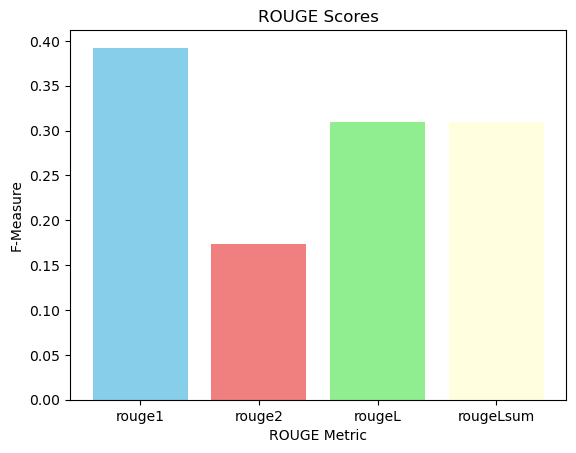

In [43]:
# Assuming `rouge_dict` contains your ROUGE scores
rouge_names = list(rouge_dict.keys())
rouge_scores = list(rouge_dict.values())

# Plotting ROUGE scores
plt.bar(rouge_names, rouge_scores, color=['skyblue', 'lightcoral', 'lightgreen', 'lightyellow'])
plt.title("ROUGE Scores")
plt.xlabel("ROUGE Metric")
plt.ylabel("F-Measure")
plt.show()


In [40]:
gen_kwargs = {"length_penalty": 0.8, 
             "num_beams": 8,
             "max_length": 128}
sample_text = dataset_samsum["test"][0]["dialogue"]
reference = dataset_samsum["test"][0]["summary"]
pipe = pipeline("summarization", model=model_ckpt)

### Generate Summaries for a Sample Text

In [41]:
print("Dialogue:")
print(sample_text)
print("\nReference Summary:")
print(reference)
print("\nModel Summary:")
print(pipe(sample_text, **gen_kwargs)[0]["summary_text"])

Your max_length is set to 128, but your input_length is only 122. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=61)


Dialogue:
Hannah: Hey, do you have Betty's number?
Amanda: Lemme check
Hannah: <file_gif>
Amanda: Sorry, can't find it.
Amanda: Ask Larry
Amanda: He called her last time we were at the park together
Hannah: I don't know him well
Hannah: <file_gif>
Amanda: Don't be shy, he's very nice
Hannah: If you say so..
Hannah: I'd rather you texted him
Amanda: Just text him 🙂
Hannah: Urgh.. Alright
Hannah: Bye
Amanda: Bye bye

Reference Summary:
Hannah needs Betty's number but Amanda doesn't have it. She needs to contact Larry.

Model Summary:
Amanda can't find Betty's number. Hannah wants to text Larry. She'd rather send him a text, but he's nice.


# Generated Summaries vs. Reference Summaries

In [42]:
# Generate summaries for a few examples
sample_texts = dataset_samsum["test"][:5]["dialogue"]
reference_summaries = dataset_samsum["test"][:5]["summary"]
generated_summaries = [pipeline("summarization", model=model_ckpt)(text, max_length=128, min_length=50)[0]["summary_text"] for text in sample_texts]

# Plotting generated vs. reference summaries
for i, (generated_summary, reference_summary) in enumerate(zip(generated_summaries, reference_summaries)):
    print(f"\nExample {i + 1}")
    print(f"Reference Summary: {reference_summary}")
    print(f"Generated Summary: {generated_summary}\n")


Your max_length is set to 128, but your input_length is only 122. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=61)



Example 1
Reference Summary: Hannah needs Betty's number but Amanda doesn't have it. She needs to contact Larry.
Generated Summary: Amanda can't find Betty's number. Hannah wants to text Larry. She'd rather send him a text, but she's not sure if she'll do it. Amanda will send her bye bye. Hannah's not sure if she'll do it, but she's not sure if she'll do it.


Example 2
Reference Summary: Eric and Rob are going to watch a stand-up on youtube.
Generated Summary: Eric will watch some of Rob's stand-ups now. Rob will watch some of Eric's stand-ups. Eric will watch some of Rob's stand-ups. Rob will watch some of Eric's stand-ups.


Example 3
Reference Summary: Lenny can't decide which trousers to buy. Bob advised Lenny on that topic. Lenny goes with Bob's advice to pick the trousers that are of best quality.
Generated Summary: Lenny wants Bob to buy two pairs of purple trousers. Bob has four black trousers. Bob will buy the first or the third pair of purple trousers. Bob will buy the firs

# summary for a random conversation from the internet
from https://www.fluentu.com/blog/english/conversation-between-two-friends-in-english/

In [44]:
random_dialogue = """\
Nathan: Hey, Alicia? 

Alicia: Oh hey, I didn’t see you there. Did you already get a table? 

Nathan: Yeah, right over here. 

Alicia: I’m glad we had time to meet up. 

Nathan: Me too. So, what’s going on? 

Alicia: Oh, not much. You? 

Nathan: Not much. Hey, how did your interview go? Wasn’t that today? 

Alicia: Oh, yeah. I think it went well. I don’t know if I got the job yet, but they said they would call in a few days. 

Nathan: Well, I’m sure you did great. Good luck. 

Alicia: Thanks. I’m just happy that it’s over. I was really nervous about it. 

Nathan: I can understand that. I get nervous before interviews, too. 

Alicia: Well, thanks for being supportive. I appreciate it. 

Nathan: Sure, no problem. 
"""

print(pipe(random_dialogue, **gen_kwargs)[0]["summary_text"])

Nathan and Alicia met up for a table. Alicia thinks her interview went well. She doesn't know if she got the job yet, but they will call in a few days.


## References
https://discuss.huggingface.co/t/fine-tuning-pegasus/1433

random_dialogue reference : https://www.fluentu.com/blog/english/conversation-between-two-friends-in-english/